<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the data from local directory
df = pd.read_csv('SMSSpamCollection', sep="\t", names=["labels", "messages"])
df.head()

,labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h2>Data Cleaning</h2>

In [3]:
df.shape

(5572, 2)

In [4]:
df.isna().sum()

labels      0
messages    0
dtype: int64

In [5]:
df.isnull().sum()

labels      0
messages    0
dtype: int64

<h2>Data Preprocessing</h2>

In [6]:
# creating objects for PorterStemmer, WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# array to store the sentences after removing all the stopwords
corpus = []
# removing all the stopwords from each sentences
for i in df['messages'].values:
    sentences = re.sub('[^a-zA-Z]', ' ', i)
    sentences = sentences.lower()
    sentences = sentences.split()
    sentences = [lemmatizer.lemmatize(word) for word in sentences if not word in set(stopwords.words('english'))]
    sentences = " ".join(sentences)
    corpus.append(sentences)

In [7]:
# displaying first five sentences in corpus
corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [8]:
# For the given problem we willl consider the vocabulary size of 5000
vocab_size = 5000
# Now we will do the one-hot encoding of corpus sentences
oneHot = [one_hot(words, vocab_size) for words in corpus]
oneHot[:5]

[[4585,
  1550,
  3954,
  2423,
  3674,
  3247,
  327,
  4998,
  4502,
  2827,
  4575,
  3853,
  2255,
  193,
  3414,
  1016],
 [3775, 3130, 3338, 2535, 273, 2103],
 [4966,
  493,
  1763,
  2877,
  3099,
  586,
  1600,
  1564,
  2056,
  2852,
  2599,
  4466,
  586,
  1477,
  493,
  2903,
  4164,
  2231,
  482,
  4331,
  2911],
 [273, 1841, 2901, 4413, 4470, 273, 4331, 1799, 2901],
 [4349, 1810, 4585, 505, 1334, 4117, 2095]]

In [9]:
# Embedding Representation
# Here we are considering sentence length of 20
sent_len = 20
# Now we will make all the sentences of one standard length
embedded_docs = pad_sequences(oneHot, padding = 'pre', maxlen = sent_len)
print(embedded_docs[:5])

[[   0    0    0    0 4585 1550 3954 2423 3674 3247  327 4998 4502 2827
  4575 3853 2255  193 3414 1016]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  3775 3130 3338 2535  273 2103]
 [ 493 1763 2877 3099  586 1600 1564 2056 2852 2599 4466  586 1477  493
  2903 4164 2231  482 4331 2911]
 [   0    0    0    0    0    0    0    0    0    0    0  273 1841 2901
  4413 4470  273 4331 1799 2901]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 4349
  1810 4585  505 1334 4117 2095]]


In [10]:
len(embedded_docs)

5572

<h2>Data Modelling</h2>

<h3>DNN - LSTM model</h3>

In [11]:
# preparing x and y for our model
x = np.array(embedded_docs)
y = pd.get_dummies(df['labels'])
y = y.iloc[:,1].values

In [12]:
# displaying shapes of x and y 
print(x.shape, y.shape)

(5572, 20) (5572,)


In [13]:
# Dividing the dataset into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4457, 20) (1115, 20) (4457,) (1115,)


In [14]:
# model creation
# total features for our model will be 40
embedding_features = 40
# here we are considering sequential model
model = Sequential()
# adding layers to the model
model.add(Embedding(vocab_size, embedding_features, input_length = sent_len))
model.add(Dropout(0.3))
# adding LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(x_train, y_train, validation_split = 0.2, shuffle = True, epochs = 10, batch_size = 64)

Epoch 1/10
56/56 [==============================] - 1s 26ms/step - loss: 0.3487 - accuracy: 0.8830 - val_loss: 0.2079 - val_accuracy: 0.9238
Epoch 2/10
56/56 [==============================] - 1s 15ms/step - loss: 0.1006 - accuracy: 0.9753 - val_loss: 0.0789 - val_accuracy: 0.9809
Epoch 3/10
56/56 [==============================] - 1s 15ms/step - loss: 0.0404 - accuracy: 0.9893 - val_loss: 0.0662 - val_accuracy: 0.9787
Epoch 4/10
56/56 [==============================] - 1s 16ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0637 - val_accuracy: 0.9798
Epoch 5/10
56/56 [==============================] - 1s 16ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0685 - val_accuracy: 0.9809
Epoch 6/10
56/56 [==============================] - 1s 17ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0868 - val_accuracy: 0.9798
Epoch 7/10
56/56 [==============================] - 1s 16ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0858 - val_accuracy: 0.9798
Epoch 8/10
56

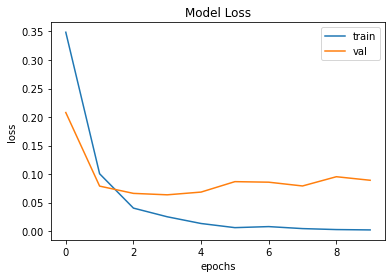

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["train", "val"], loc ="upper right")
# plt.legend(['train', 'val'], loc = ['upper left'])
plt.show()

<h2>Performance Metrics and Accuracy</h2>

In [17]:
y_pred = model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print("Accuracy score: ", ac)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy score:  0.9847533632286996


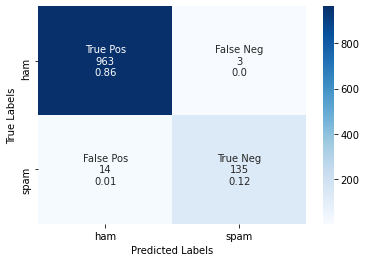

In [18]:
# Confusion matrix
group_names = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
group_counts = cm.flatten()
group_percentages = np.round(cm.flatten()/sum(cm.flatten()), 2)
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
 zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<h3>Naive Bayes model</h3>

In [19]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB().fit(x_train, y_train)
y_pred = model_nb.predict(x_test)
ac_nb = accuracy_score(y_test, y_pred)
print("Accuracy score:", ac_nb)

Accuracy score: 0.8053811659192825


<h3>SVM model</h3>

In [20]:
from sklearn.svm import SVC
model_svc = SVC(random_state = 43).fit(x_train, y_train)
y_pred = model_svc.predict(x_test)
ac_svc = accuracy_score(y_test, y_pred)
print("Accuracy score:", ac_svc)

Accuracy score: 0.8798206278026905


<h3>Random Forest model</h3>

In [21]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state = 43).fit(x_train, y_train)
y_pred = model_rf.predict(x_test)
ac_rf = accuracy_score(y_test, y_pred)
print("Accuracy score:", ac_rf)

Accuracy score: 0.9228699551569507


<h3>Comparing all models</h3>

In [22]:
models = ["ANN - LSTM", "Naive Bayes", "Random Forest", "SVM"]
data = {'Models':models, 'Accuracy':[ac, ac_nb, ac_rf, ac_svc]}
dfg = pd.DataFrame(data, columns=['Models',"Accuracy"])
display(dfg.style.apply(lambda x: ['background: lightblue' if i == max(dfg["Accuracy"]) else '' for i in dfg["Accuracy"]]))

,Models,Accuracy
0,ANN - LSTM,0.984753
1,Naive Bayes,0.805381
2,Random Forest,0.922870
3,SVM,0.879821
